# Task 2.5 - Homogenized cubic lattice metamaterials

## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from keras import optimizers
from keras import losses
from keras import callbacks

from src.models import CustomFFNN, CubicAnisoInvariantsICNN, DeformationICNN
from src.data_import import load_data, get_train_dataset, get_pann_dataset, get_naive_dataset
from src.plots import plot_loss, plot_stress_predictions
from src.utils import get_scores
from src.plot_and_predict import predict_and_plot_pann_model, predict_and_plot_naive_model
from src.analytic_potential import get_hyperelastic_potential
from src.observability import check_objectivity_condition, generate_augmented_dataset

2024-12-15 14:06:26.536297: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 14:06:26.540414: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 14:06:26.552367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 14:06:26.572062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 14:06:26.577941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 14:06:26.592979: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
data_dir = os.path.abspath('task5_data')
train_names = ['biaxial', 'shear', 'uniaxial', 'volumetric']
test_names = ['test1', 'test2', 'test3']
train_paths = {name: os.path.join(data_dir, f'BCC_{name}.txt') for name in train_names}
test_paths = {name: os.path.join(data_dir, f'BCC_{name}.txt') for name in test_names}

## 2.5.1 - Data preperation

### Load Data

In [3]:
def load_data_task_5(path: os.PathLike) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    F, P, _ = load_data(path)
    W = get_hyperelastic_potential(F)
    return F, P, W

In [4]:
train_data = {
    key: load_data_task_5(path) for key, path in train_paths.items()
}
test_data = {
    key: load_data_task_5(path) for key, path in test_paths.items()
}

### Visualize

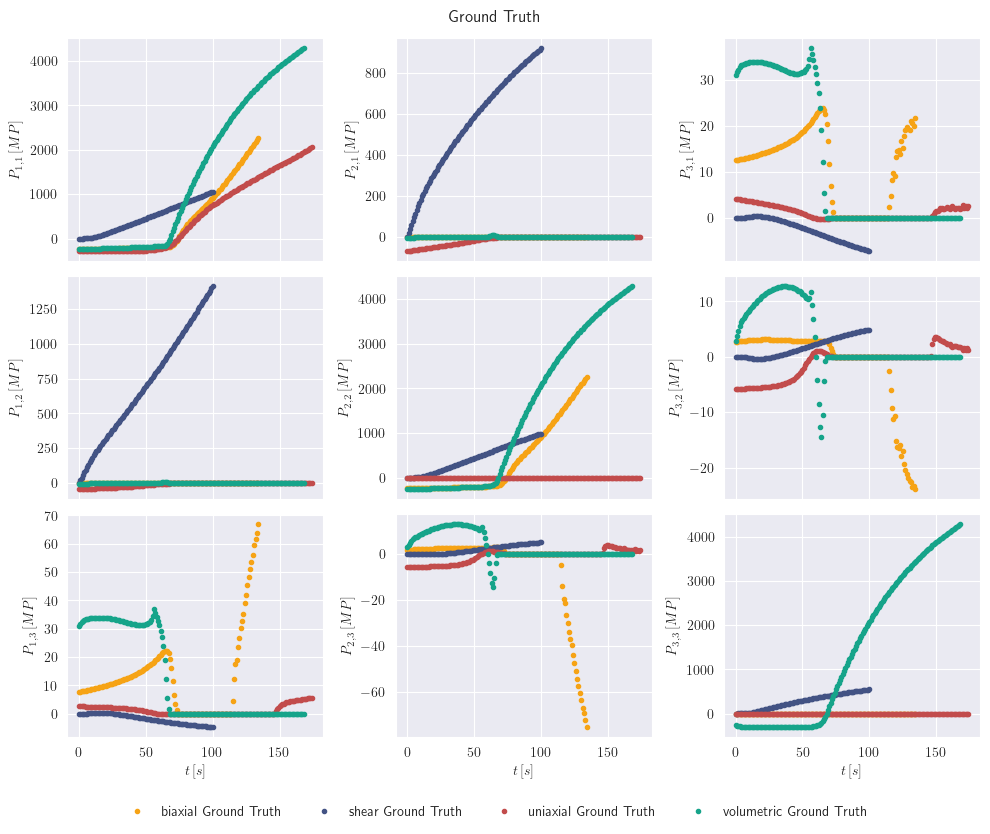

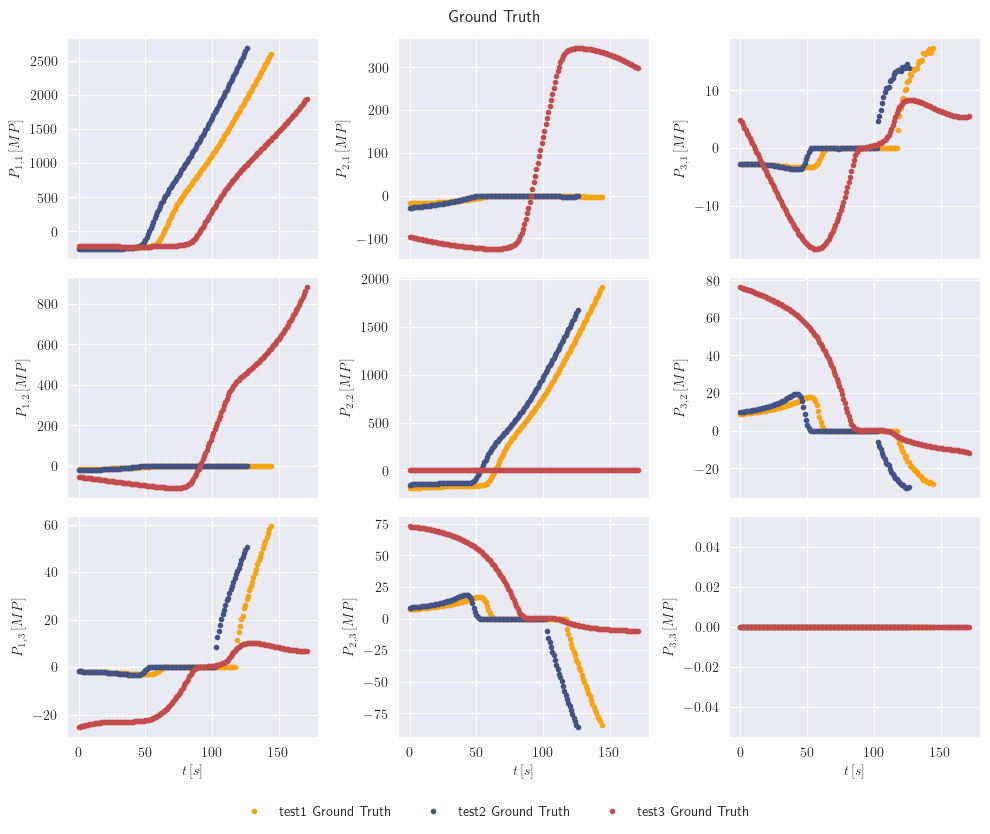

In [5]:
plot_stress_predictions({key: value[1].numpy().reshape((-1, 9)) for key, value in train_data.items()}, markevery_label=1, suptitle='Ground Truth - Traindata')
plot_stress_predictions({key: value[1].numpy().reshape((-1, 9)) for key, value in test_data.items()}, markevery_label=1, suptitle='Ground Truth - Testdata')

### Scaling

benefit -> nummerically stable

In [6]:
def scale_data(unscaled_data: dict[str, tuple[tf.Tensor, tf.Tensor, tf.Tensor]], scale: float):
    scaled_data = {}
    for key, (F, P, W) in unscaled_data.items():
        P_scaled = P / scale
        W_scaled = W / scale
        scaled_data[key] = (F, P_scaled, W_scaled)
        print(f'Max P in {key}: {tf.reduce_max(P_scaled)}')
        print(f'Max W in {key}: {tf.reduce_max(W_scaled)}')
    return scaled_data

In [7]:
scale = 4_000.0
scaled_train_data = scale_data(train_data, scale)
scaled_test_data = scale_data(test_data, scale)

Max P in biaxial: 0.5641509890556335
Max W in biaxial: 0.006089380476623774
Max P in shear: 0.3535967469215393
Max W in shear: 0.0011132812360301614
Max P in uniaxial: 0.5137190222740173
Max W in uniaxial: 0.007642469368875027
Max P in volumetric: 1.0698578357696533
Max W in volumetric: 0.05231127515435219
Max P in test1: 0.6476467251777649
Max W in test1: 0.006828701123595238
Max P in test2: 0.6702445149421692
Max W in test2: 0.007148208562284708
Max P in test3: 0.48603224754333496
Max W in test3: 0.011808986775577068


## 2.5.2 - Invariant based Model

In [ ]:
invariant_train_keys = ['uniaxial', 'shear']
invariant_features, invariant_labels = get_train_dataset(scaled_train_data, invariant_train_keys)

early_stoping = callbacks.EarlyStopping(monitor='loss', patience=8, start_from_epoch=1000)
invariant_model = CubicAnisoInvariantsICNN(
    hidden_sizes=[32, 32, 1],
    activations=['softplus', 'softplus', 'linear']
)
invariant_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
invariant_h = invariant_model.fit(invariant_features, invariant_labels, batch_size=32, epochs=3000, verbose=0, callbacks=[early_stoping])
invariant_loss = invariant_h.history['loss']
plot_loss(invariant_loss)

In [ ]:
_ = predict_and_plot_pann_model(invariant_model, {key: scaled_train_data[key] for key in invariant_train_keys}, suptitle='Invariant based Model - Traindata -')
_ = predict_and_plot_pann_model(invariant_model, scaled_test_data, suptitle='Invariant based Model - Testdata -')

## 2.5.3 - Deformation-gradient based neural network model

In [ ]:
deformation_train_keys = ['uniaxial', 'shear']
deformation_features, deformation_labels = get_train_dataset(scaled_train_data, deformation_train_keys)

early_stoping = callbacks.EarlyStopping(monitor='loss', patience=8, start_from_epoch=1000)
deformation_model = DeformationICNN(
    hidden_sizes=[32, 32, 1],
    activations=['softplus', 'softplus', 'linear']
)
deformation_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)

deformation_h = deformation_model.fit(deformation_features, deformation_labels, batch_size=32, epochs=3000, verbose=0, callbacks=[early_stoping])
deformation_loss = deformation_h.history['loss']
plot_loss(deformation_loss, suptitle='Deformation ICNN')

In [ ]:
_ = predict_and_plot_pann_model(deformation_model, {key: scaled_train_data[key] for key in deformation_train_keys}, suptitle='Deformation ICNN - Traindata -')
_ = predict_and_plot_pann_model(deformation_model, scaled_test_data, suptitle='Deformation ICNN - Testdata -')

### Test objectivity conditions

In [ ]:
check_objectivity_condition(deformation_model, deformation_features, eps=1e-6, seed=2643)

## 2.5.4 - Data augmentation

In [8]:
def strings_containing_substrings(string_list: list[str], substring_list: list[str]) -> list[str]:
    return [string for substring in substring_list for string in string_list if substring.lower() in string.lower()]

--------------------------------------------------  8 Observers  --------------------------------------------------


/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


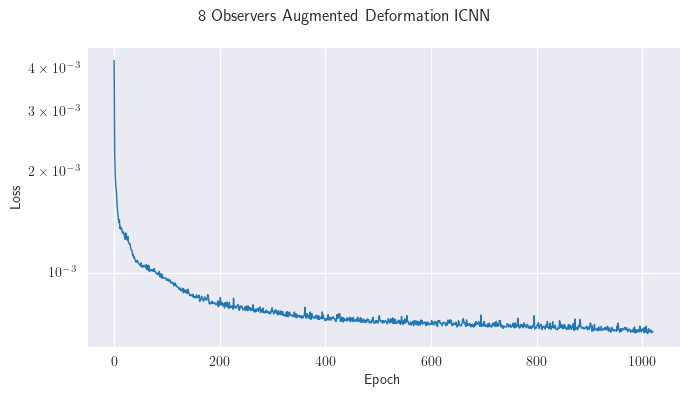

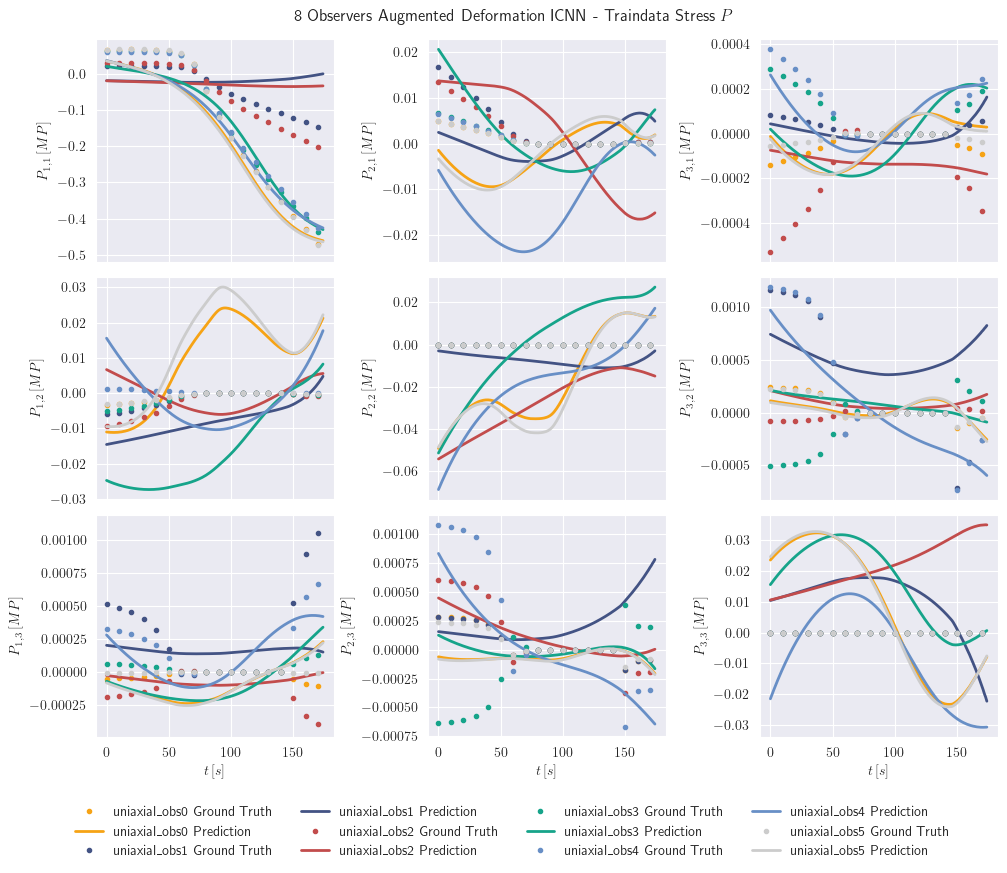

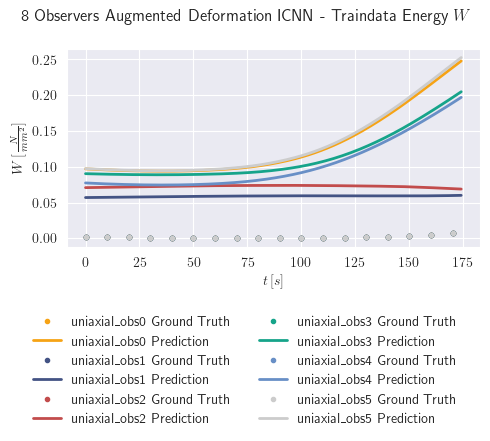

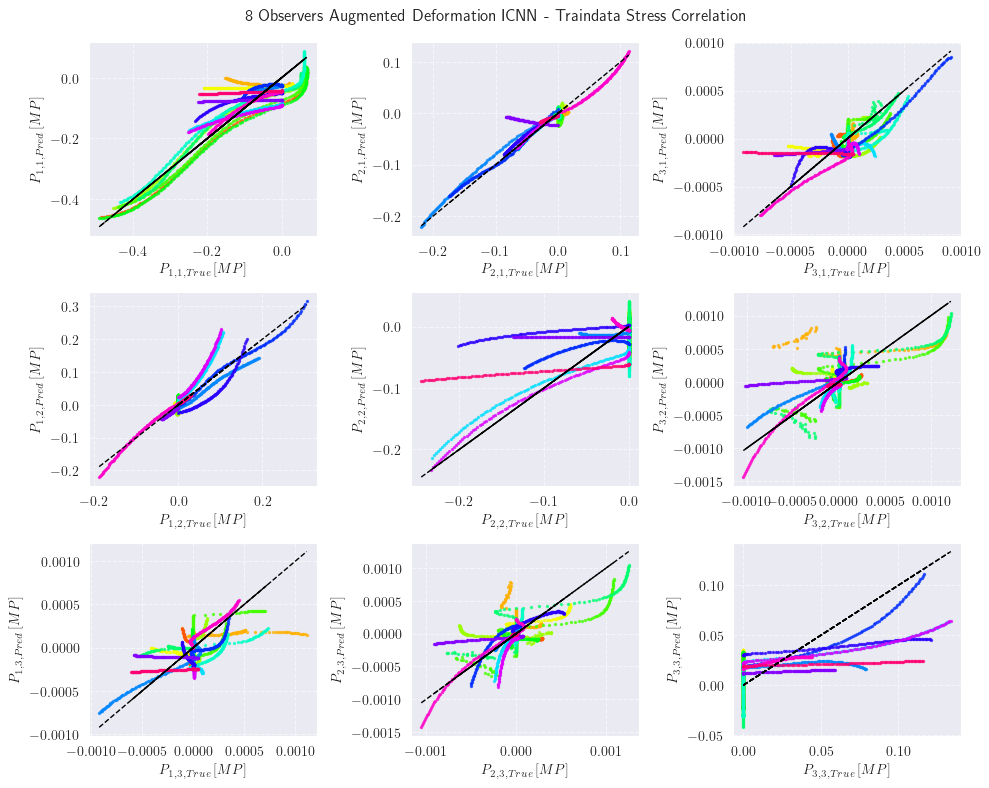

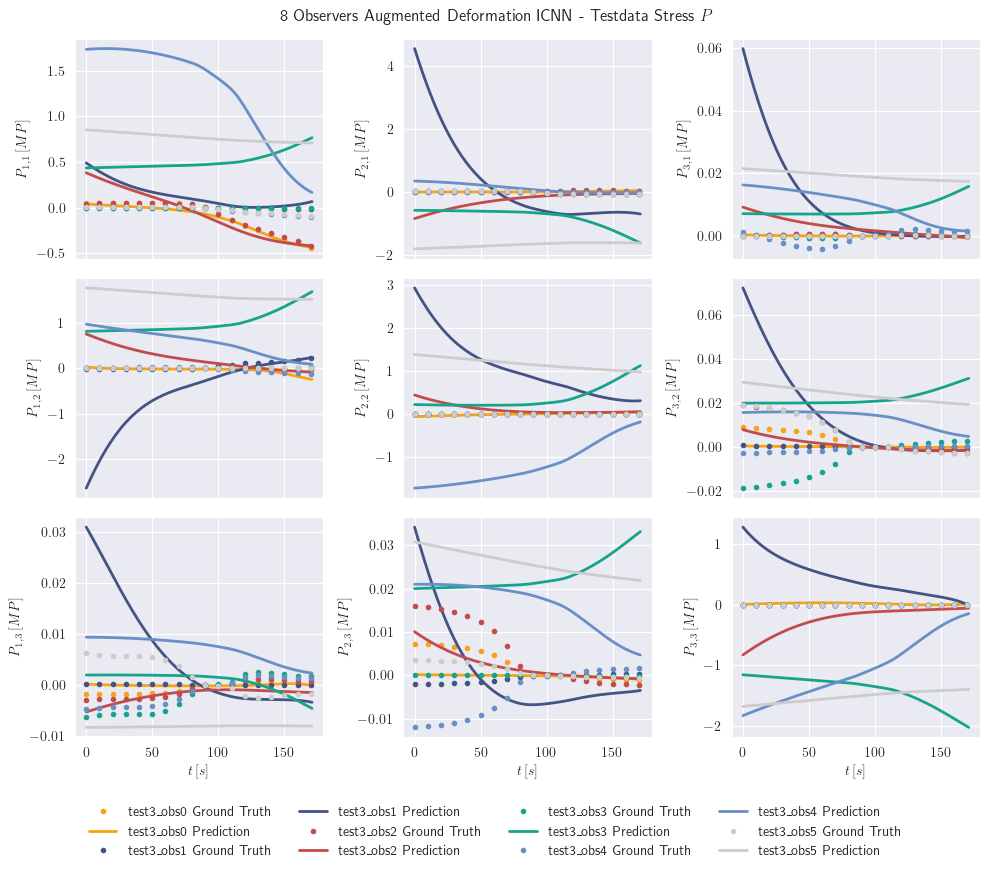

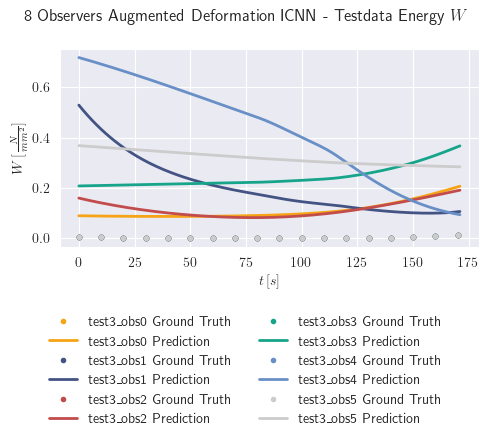

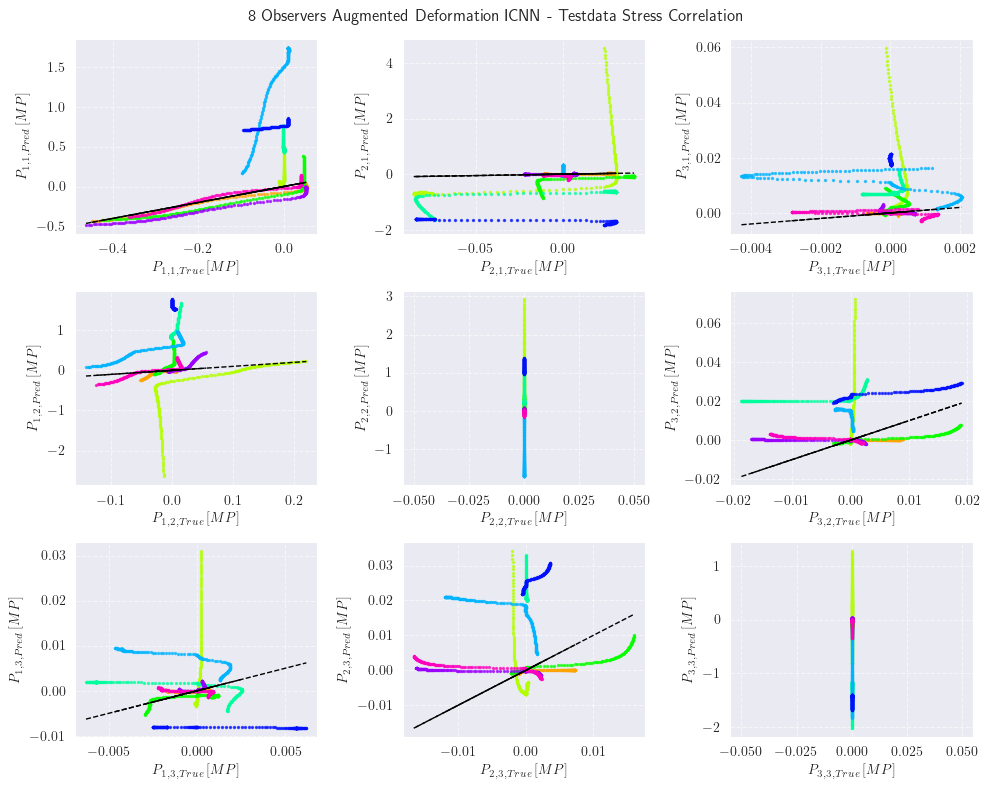

--------------------------------------------------  16 Observers  --------------------------------------------------


/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


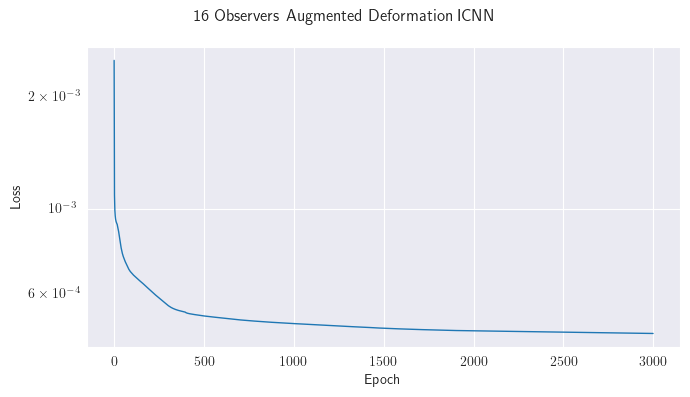

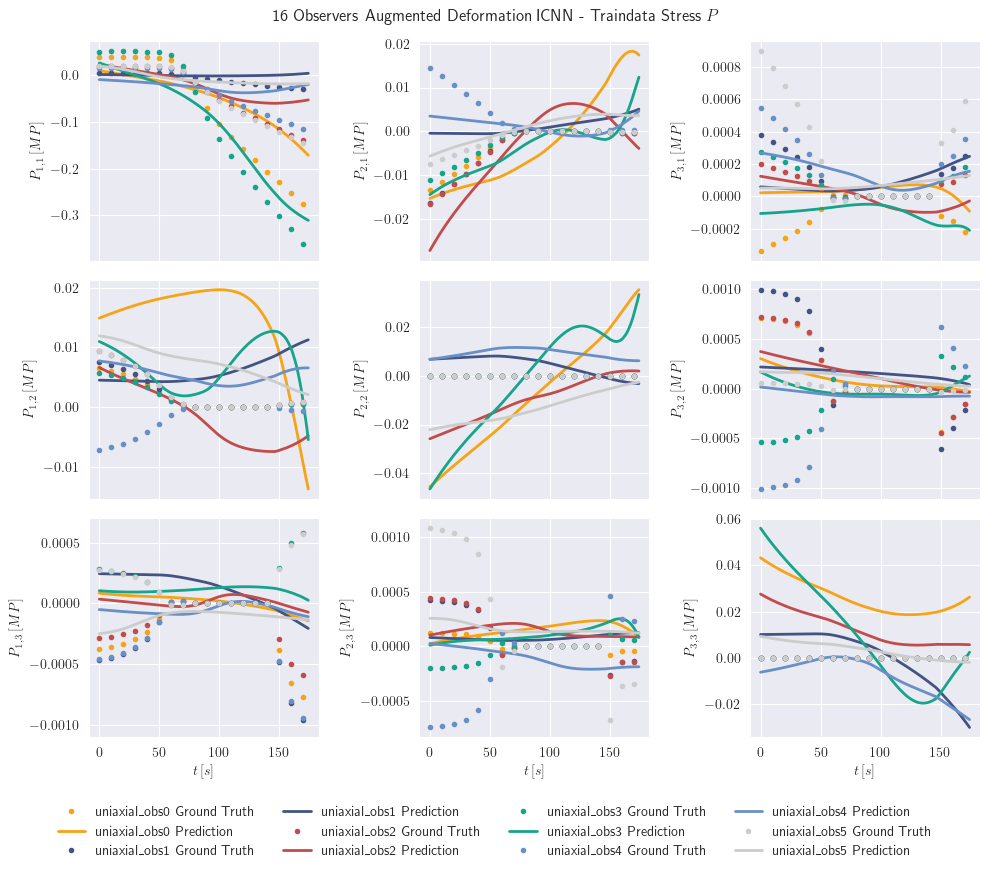

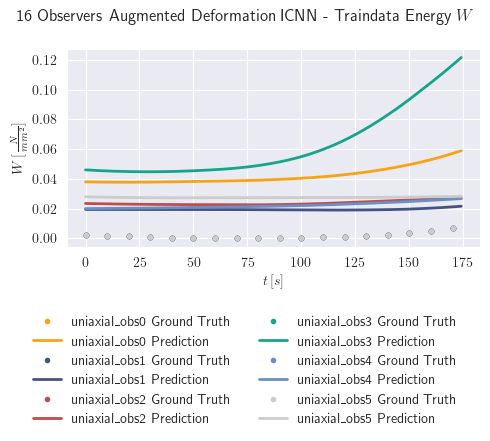

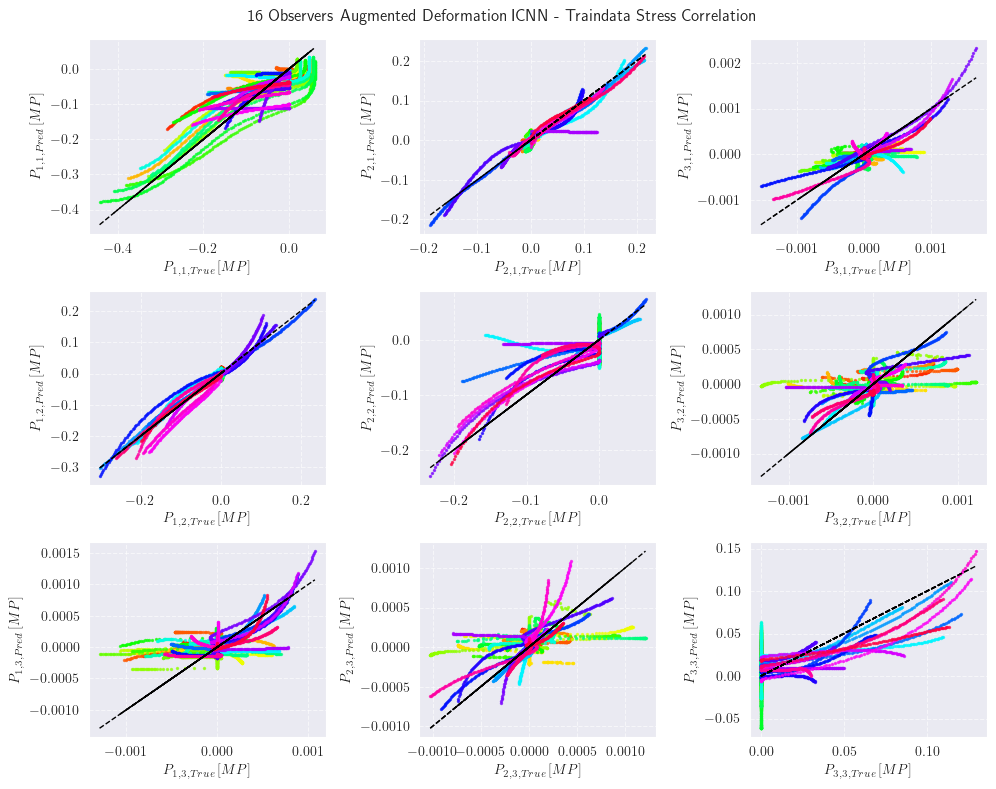

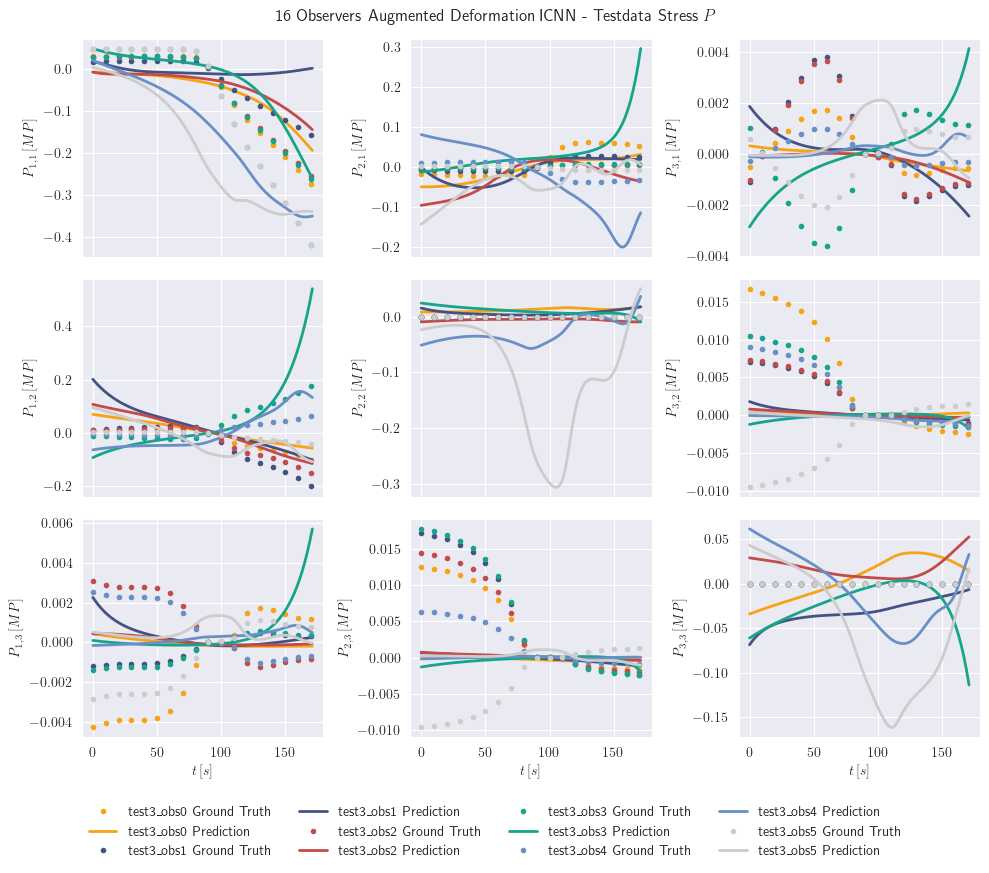

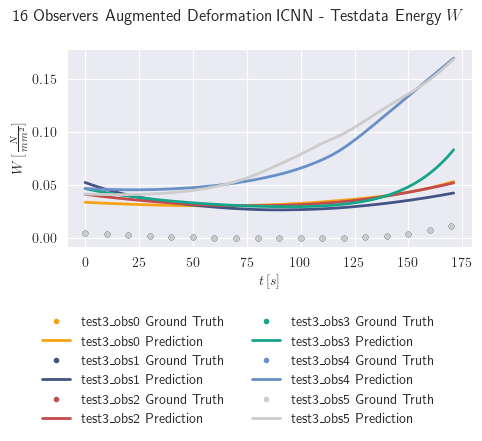

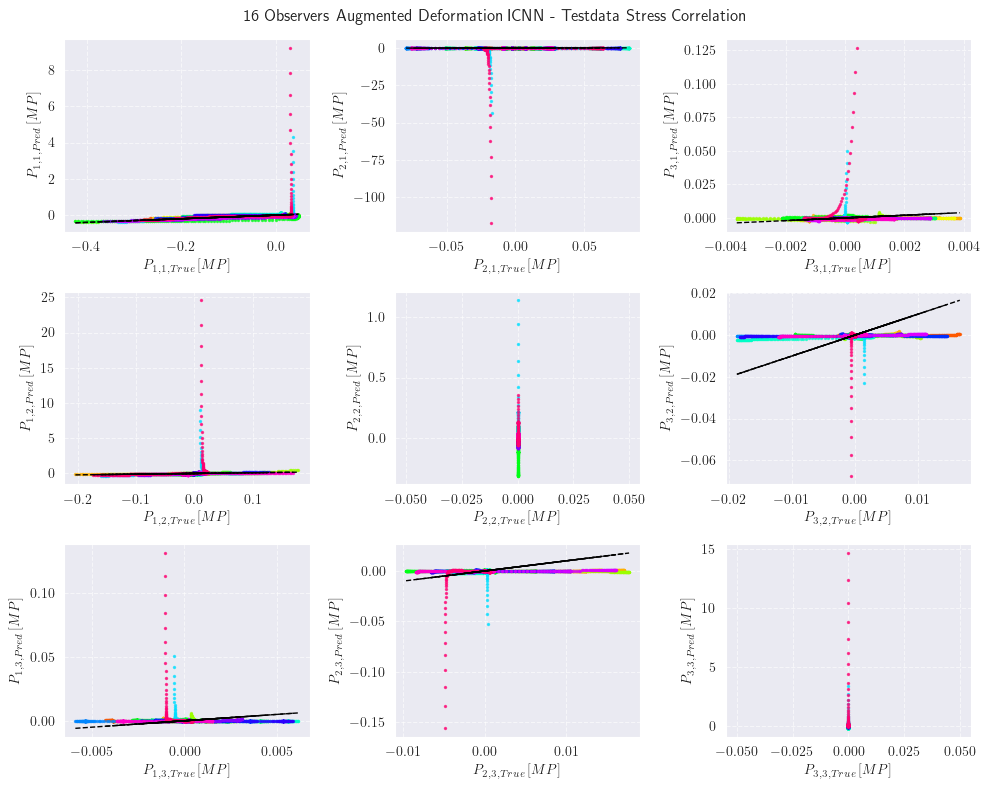

--------------------------------------------------  32 Observers  --------------------------------------------------


/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


KeyboardInterrupt: 

In [9]:
aug_deformation_train_keys = ['uniaxial', 'shear']
aug_deformation_test_keys = ['test3']
deformation_features, _ = get_train_dataset(scaled_train_data, aug_deformation_train_keys)

for n_observers in [8, 16, 32, 64, 128]:
    print('-'*50, f' {n_observers} Observers ', '-'*50)
    aug_train_data = generate_augmented_dataset({key: scaled_train_data[key] for key in aug_deformation_train_keys}, n_observers)
    aug_test_data = generate_augmented_dataset({key: scaled_test_data[key] for key in aug_deformation_test_keys}, n_observers)

    aug_deformation_features, aug_deformation_labels = get_train_dataset(
        aug_train_data, 
        strings_containing_substrings(aug_train_data.keys(), aug_deformation_train_keys)
    )

    early_stoping = callbacks.EarlyStopping(monitor='loss', patience=10, start_from_epoch=1000)
    aug_deformation_model = DeformationICNN(
        hidden_sizes=[32, 32, 1],
        activations=['softplus', 'softplus', 'linear']
    )
    aug_deformation_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss=losses.MeanSquaredError()
    )

    aug_deformation_h = aug_deformation_model.fit(aug_deformation_features, aug_deformation_labels, batch_size=64, epochs=2000, verbose=0, callbacks=[early_stoping])
    aug_deformation_loss = aug_deformation_h.history['loss']
    plot_loss(aug_deformation_loss, suptitle=f'{n_observers} Observers Augmented Deformation ICNN')

    is_obs = check_objectivity_condition(aug_deformation_model, deformation_features, eps=1e-6, seed=2643)
    _ = predict_and_plot_pann_model(
        aug_deformation_model, 
        {key: aug_train_data[key] for key in strings_containing_substrings(aug_train_data.keys(), aug_deformation_train_keys)}, 
        suptitle=f'{n_observers} Observers Augmented Deformation ICNN - Traindata -'
    )
    _ = predict_and_plot_pann_model(aug_deformation_model, aug_test_data, suptitle=f'{n_observers} Observers Augmented Deformation ICNN - Testdata -')
    if is_obs:
        break